# A Study on the Impact of Syrian Refugees on Jordan

In 2011, the 'Arab Spring' erupted across the Middle East and North Africa, leading to the outbreak of the Syrian Civil War. Given its proximity, Jordan became a primary destination for a massive influx of refugees fleeing the conflict.

Back to more past, there was a economic depression named **'Subprime Mortgage Crisis'**. It effected all the nations, Jordan couldn't avoid it too. But Jordan has a chance to grow economy after the depression.

While Jordan showed potential for economic recovery following the 2008 global financial crisis, this momentum was significantly hampered by the refugee crisis. This study, therefore, aims to analyze and quantify the multifaceted impacts of the Syrian refugee influx on Jordan.

First, these are economic indicators like GDP, GDP growth, inflation, unemployment. And refugees indicator, total renewable water resource indicator. We will analysis the basic economic indicators of Jordan focusing 2011.

In [88]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from functools import reduce
import numpy as np
from matplotlib.ticker import MaxNLocator


# Data Management
project_root = Path.cwd()

def get_data_path(dataname):
    data_path = project_root / 'data' / dataname
    return data_path

def get_Jordan_row(dataname, skiprow, start, end):
    get_data_path(dataname)
    tmp = pd.read_csv(get_data_path(dataname), skiprows = skiprow, sep = ',')
    tmp = tmp[tmp['Country Name'] == 'Jordan']
    tmp = tmp.loc[:, start:end].copy()
    return tmp

def transform_data(df_wide, col_name):
    df_long = df_wide.T
    df_long = df_long.reset_index()
    df_long.columns = ['Year', col_name]
    df_long['Year'] = df_long['Year'].astype(int)
    return df_long

# Jordan Refugees from Syria data
Jordan_Refugees_org = pd.read_csv(get_data_path('WorldBank_Jordan_Refugees.csv'))
Jordan_Refugees = Jordan_Refugees_org.loc[:, ['Year', 'Refugees']].copy()

# Jordan Total Water Resource data
Jordan_Water_org = pd.read_csv(get_data_path('WorldBank_totalWater.csv'))
Jordan_Water = Jordan_Water_org[Jordan_Water_org['REF_AREA_LABEL'] == 'Jordan']
Jordan_Water = Jordan_Water.iloc[0].fillna(Jordan_Water.iloc[1])
Jordan_Water = Jordan_Water.to_frame(name = 'Water')
Jordan_Water = Jordan_Water.reset_index()
Jordan_Water.columns = ['Year', 'Water']
Jordan_Water = Jordan_Water.set_index('Year')
Jordan_Water = Jordan_Water.loc['2000':'2022']
Jordan_Water.reset_index(inplace = True)
Jordan_Water['Year'] = Jordan_Water['Year'].astype(int)

data_dictionary = {
    'WorldBank_GDP.csv' : 'GDP',
    'WorldBank_gdpGrowth.csv' : 'gdpGrowth',
    'WorldBank_Inflation.csv' : 'Inflation',
    'WorldBank_Unemployment.csv' : 'Unemployment',
}

merge_data = []
for filename, col_name in data_dictionary.items():
    Jordan_wide = get_Jordan_row(filename, 4, '2000', '2022')
    Jordan_long = transform_data(Jordan_wide, col_name)
    merge_data.append(Jordan_long)

merge_data.append(Jordan_Refugees)
merge_data.append(Jordan_Water)

Jordan_indexes = reduce(lambda left, right: pd.merge(left, right, on = 'Year', how = 'outer'), merge_data)

print(Jordan_indexes)



    Year           GDP  gdpGrowth  Inflation  Unemployment  Refugees  Water
0   2000  8.460790e+09   4.245712   0.666881        13.700       0.0  0.937
1   2001  8.975815e+09   5.269958   1.772204        14.700       0.0  0.937
2   2002  9.582511e+09   5.783808   1.832994        15.300       5.0  0.937
3   2003  1.019563e+10   4.161668   1.630000        14.500      28.0  0.937
4   2004  1.141171e+10   8.567214   3.361868        14.628      37.0  0.937
5   2005  1.258900e+10   8.146595   3.493685        14.800      40.0  0.937
6   2006  1.505698e+10   8.092975   6.251725        14.000      42.0  0.937
7   2007  1.711044e+10   8.176170   4.743906        13.100      41.0  0.937
8   2008  2.265872e+10   7.220386  13.971231        12.700      44.0  0.937
9   2009  2.453788e+10   5.023710  -0.739070        12.900     138.0  0.937
10  2010  2.713380e+10   2.314834   4.845519        12.500     198.0  0.937
11  2011  2.952415e+10   2.737180   4.162442        12.900     193.0  0.937
12  2012  3.

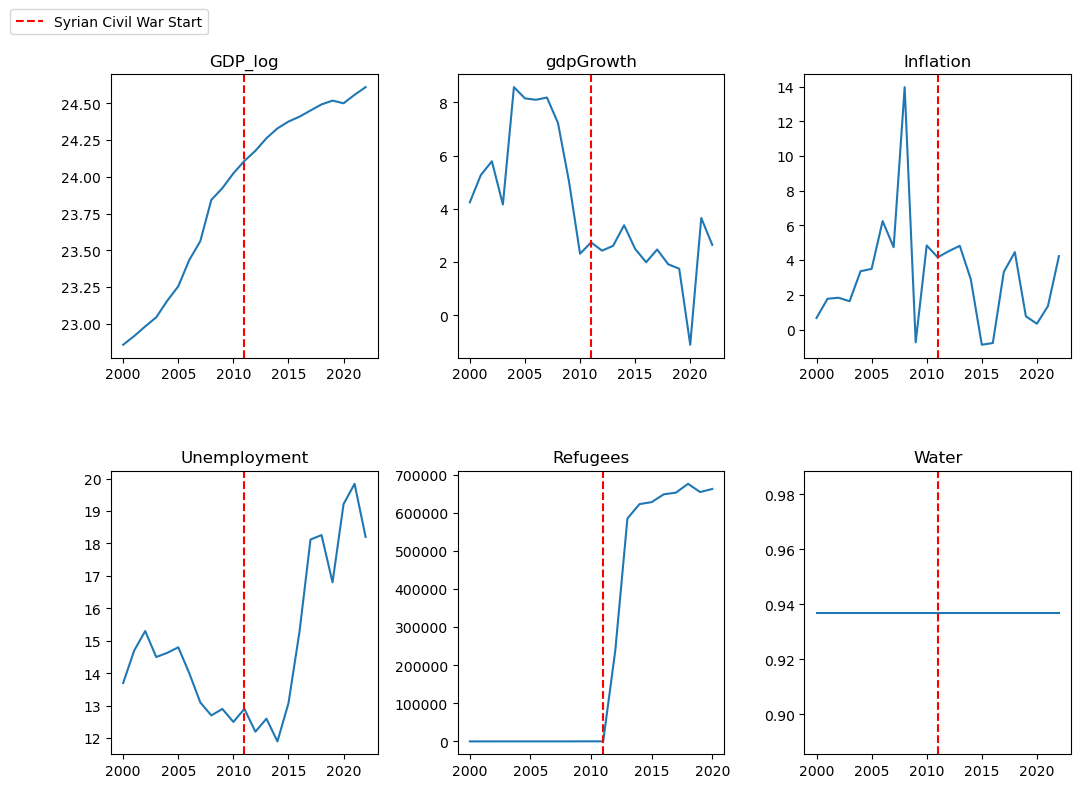

In [89]:
# Visualizing

Jordan_indexes['GDP'] = np.log(Jordan_indexes['GDP'])
Jordan_indexes = Jordan_indexes.rename(columns={'GDP' : 'GDP_log'})
Jordan_long = pd.melt(Jordan_indexes, id_vars = ['Year'], var_name = 'indicator', value_name = 'value')
indicator_list = Jordan_long['indicator'].unique()

fig, axs = plt.subplots(nrows = 2,ncols = 3, figsize = (12, 8))
for ax, indicator in zip(axs.flatten(), indicator_list):
    plot_data = Jordan_long[Jordan_long['indicator'] == indicator]
    ax.plot(plot_data['Year'], plot_data['value'])
    ax.set_title(indicator)
    ax.axvline(x=2011, color='red', linestyle='--', linewidth=1.5, label='Syrian Civil War Start')

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.01, 0.99))
fig.subplots_adjust(
    left=0.1,      # 왼쪽 여백
    right=0.9,     # 오른쪽 여백
    top=0.9,      # 위쪽 여백 (suptitle과의 간격 확보)
    bottom=0.05,   # 아래쪽 여백
    wspace=0.3,    # 서브플롯 좌우 간격
    hspace=0.4     # 서브플롯 상하 간격
)

plt.savefig('Jordan_indexes.png')
plt.show()

# It's absolute that **year of 2011 was a 'turning point'** for Jordan

Although I used the log scale on GDP indicator, it seems that Jordan's GDP is growing well. But absolutely the year of 2011 is an **inflection point** of Jordan's GDP. It's obvious in indicator of GDP growth. Before 2011, Jordan was a great growing nation that has about 6-8% growth. But after 2011, Jordan even faced the **minus growth**.

And the unemployment index had grown up as the number of Syrian refugees boombed.

# Water Resource Data Analysis

In these indicators, there is a strange indicator. The Total Renewable Water Resources indicator presents a unique characteristic: it remains nearly constant. This is accurate, as this World Bank metric reflects a country's long-term average and does not exhibit significant annual volatility. Thus, it serves as a baseline measure of absolute water capacity.

Jordan is M.E country. For M.E, the water resource is **invaluable**. So they are sensitive about **Population**. If the population going up, they will face the critial water shortage.

Following datas show the water resource condition of Jordan.

In [90]:
# Clustering

def clustering(dataname, std, error, start, end):
    data_path = get_data_path(dataname)
    data = pd.read_csv(data_path, skiprows=4, sep=',')
    sel_columns = ['Country Code']+ [str(n) for n in range(start, end+1)]
    data_refined = data.loc[:, sel_columns]
    data_refined.set_index('Country Code', inplace=True)
    peer_countries_dict = {}
    for year in data_refined.columns:
        std_value = data_refined.loc[std, year]
        min_val = std_value * ((100-error) / 100)
        max_val = std_value * ((100+error) / 100)
        mask = data_refined[year].between(min_val, max_val)
        peer_countries = data_refined[mask].index.tolist()
        if std in peer_countries:
            peer_countries.remove(std)
        peer_countries_dict[year] = peer_countries
    return peer_countries_dict

# Economic Cluster
Jordan_cluster = clustering('WorldBank_GDP.csv', 'JOR', 10, 2000, 2022)

Water_org = pd.read_csv(get_data_path('WorldBank_totalWater.csv'))
Water_org = Water_org.set_index('REF_AREA')
Water_org = Water_org.groupby('REF_AREA').sum(numeric_only=True)
water_cluster = {}
water_cluster_mean = {}
water_cluster_median = {}
for year, countries in Jordan_cluster.items():
    clusters = [c for c in countries if c in Water_org.index]
    water_cluster[year] = clusters

for year, clusters in water_cluster.items():
    cluster_Water_mean = Water_org.loc[clusters, year].mean()
    water_cluster_mean[year] = cluster_Water_mean
    cluster_Water_median = Water_org.loc[clusters, year].median()
    water_cluster_median[year] = cluster_Water_median

print(water_cluster_mean)
print(water_cluster_median)

# Geographical Cluster (Arab)
middle_east_cluster_codes = [
    'DZA', 'BHR', 'COM', 'DJI', 'EGY', 'IRQ', 'KWT',
    'LBN', 'LBY', 'MRT', 'MAR', 'OMN', 'PSE', 'QAT', 'SAU',
    'SOM', 'SDN', 'SYR', 'TUN', 'ARE', 'YEM'
]
me_water_cluster_mean = {}
me_water_cluster_median = {}
for year in range(2000, 2023):
    cluster_water_mean = Water_org.loc[middle_east_cluster_codes, str(year)].mean()
    me_water_cluster_mean[str(year)] = cluster_water_mean
    cluster_water_median = Water_org.loc[middle_east_cluster_codes, str(year)].median()
    me_water_cluster_median[str(year)] = cluster_water_median

print(me_water_cluster_mean)
print(me_water_cluster_median)


{'2000': np.float64(238.21718181818184), '2001': np.float64(132.24445454545454), '2002': np.float64(194.036125), '2003': np.float64(248.08299999999994), '2004': np.float64(628.1189999999999), '2005': np.float64(651.86875), '2006': np.float64(649.7675), '2007': np.float64(433.635), '2008': np.float64(200.28799999999998), '2009': np.float64(77.42942857142857), '2010': np.float64(146.3832), '2011': np.float64(75.12157142857141), '2012': np.float64(488.509), '2013': np.float64(522.0886666666667), '2014': np.float64(488.509), '2015': np.float64(314.05583333333334), '2016': np.float64(279.2442857142857), '2017': np.float64(335.2321428571428), '2018': np.float64(324.01137500000004), '2019': np.float64(127.63419999999999), '2020': np.float64(69.58099999999999), '2021': np.float64(104.17666666666666), '2022': np.float64(159.96349999999998)}
{'2000': 122.0, '2001': 34.94, '2002': 22.8815, '2003': 12.806, '2004': 608.3349999999999, '2005': 644.9, '2006': 644.9, '2007': 212.635, '2008': 200.287999

Before visualizing Jordan's water resource data, I want to explain my thought.

Jordan had a big change of their condition. Syria civil war outbroke in 2011, and it has been more than 10 years.
So Jordan can't join fixed group because Jordan had a lot of changes.

So, I tried **Dynamic Clustering**. Every years, I clustered countries whose have GDP within 10% from Jordan. So, the cluster of each years could be different.

And water resource is not a result of GDP. So, of course we check the GDP group, I gathered the middle east countries as **Geographic Group**.

I believe that Economic, geographic clusters make big reliability.

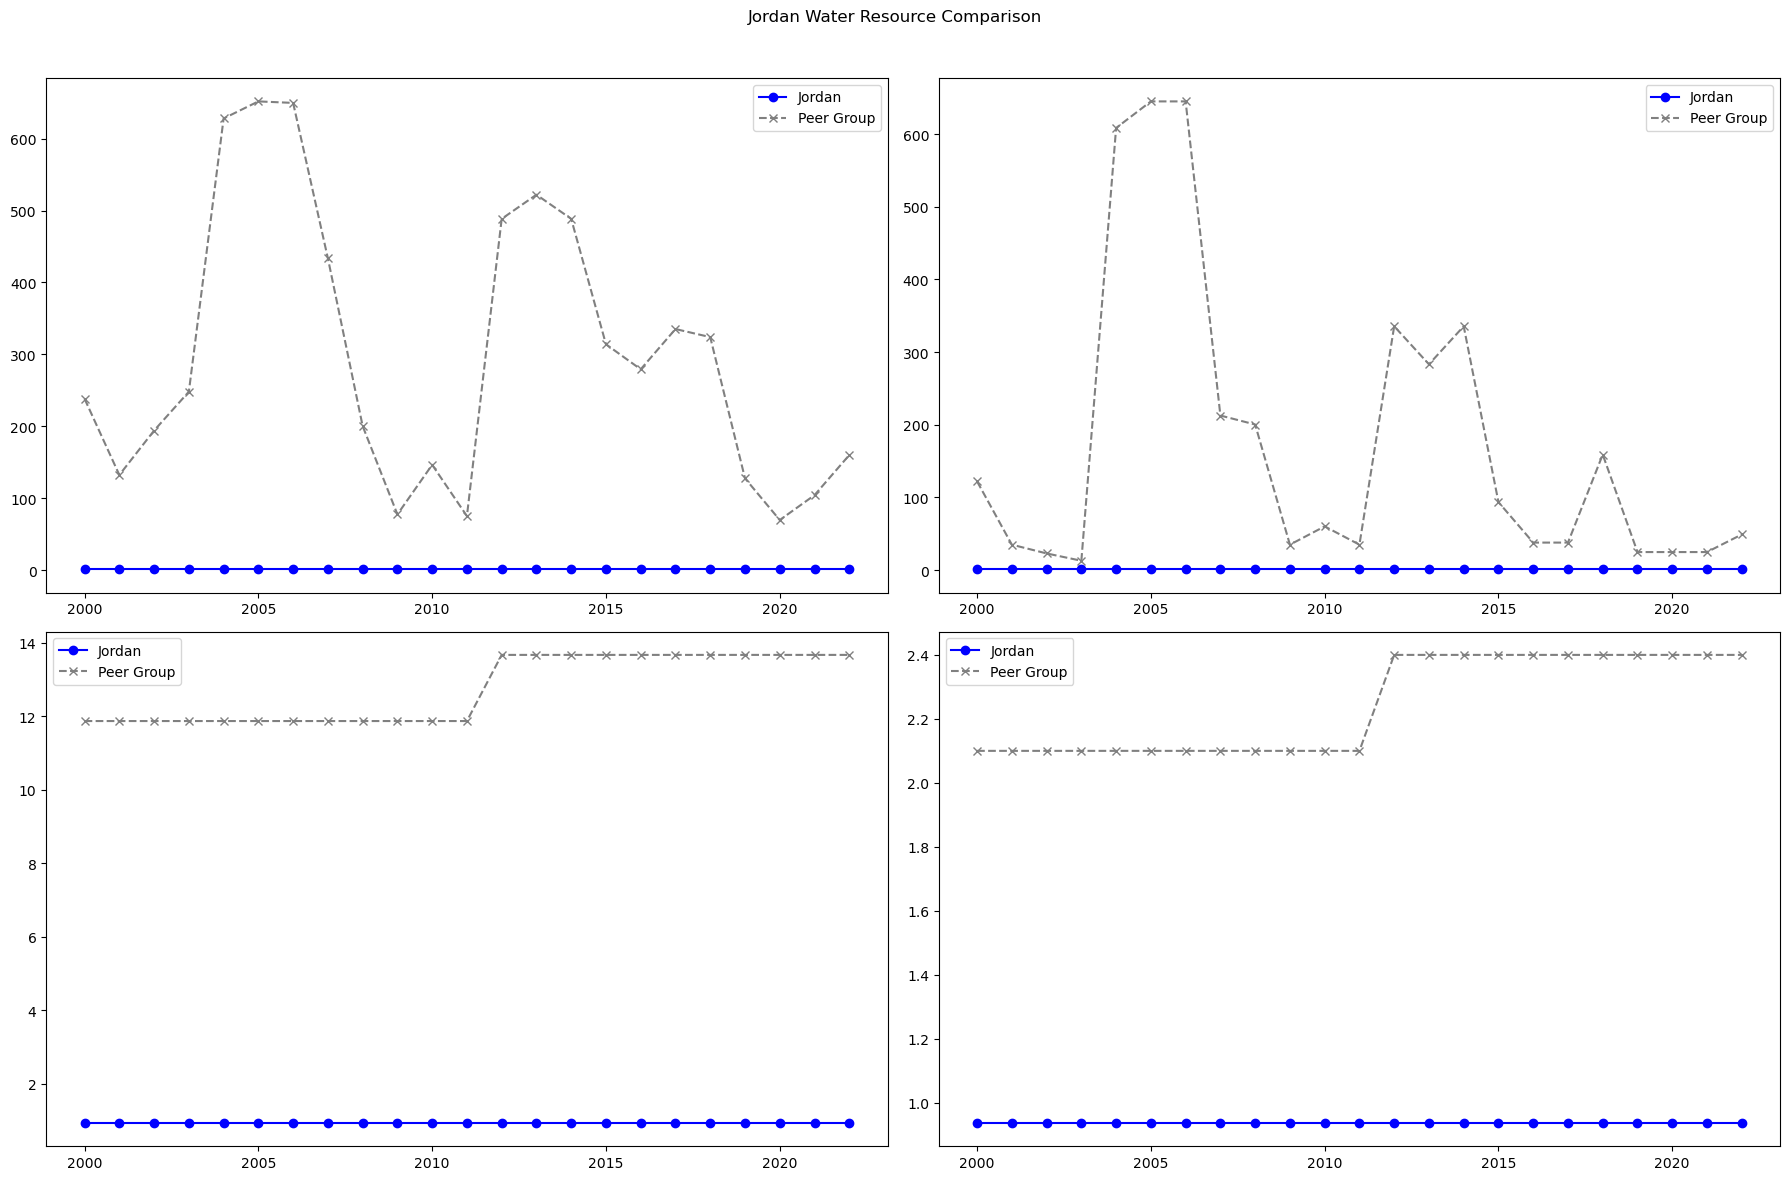

In [91]:
# Visualizing

plot_data_list = [
    (water_cluster_mean, 'Jordan VS GDP Peer Group (mean)'),
    (water_cluster_median, 'Jordan VS GDP Peer Group (median)'),
    (me_water_cluster_mean, 'Jordan VS M.E Group (mean)'),
    (me_water_cluster_median, 'Jordan VS M.E Group (median)')
]

fig, axs = plt.subplots(2,2, figsize = (18,12))
fig.suptitle('Jordan Water Resource Comparison')

for ax, (peer_data_dict, title) in zip(axs.flatten(), plot_data_list):
    years = list(peer_data_dict.keys())
    peer_values = (peer_data_dict.values())
    ax.plot(Jordan_Water.index, Jordan_Water['Water'], label = 'Jordan', color = 'blue', marker = 'o', zorder=10)
    ax.plot(years, peer_values, label = 'Peer Group', color = 'gray', marker= 'x', linestyle = '--')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
    ax.legend()

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

The analysis reveals a stark reality: Jordan's water resources are consistently and significantly lower than the median of both its economic and geographic peer groups. This highlights a condition of extreme water scarcity. It was under these pre-existing vulnerable conditions that Jordan absorbed a large refugee population, exacerbating the demographic pressure on its limited resources.